In [1]:
%matplotlib inline

In [2]:
import networkx as nx
import pandas as pd
# import projx as px fails in python3
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as clrs
import seaborn as sns

In [3]:
plt.rcParams['figure.figsize'] = (12, 7)

In [4]:
def prob_dist(itrbl):
    count = {}
    for i in itrbl:
        count.setdefault(i, 0)
        count[i] += 1
    sr = pd.Series(count)
    prob = sr.apply(lambda x: float(x) / len(itrbl))
    return prob


def basic_graph_stats(g):
    stats = {
        "num_nodes": len(g),
        "num_edges": len(g.edges()),
        "density": nx.density(g),
        "diameter": nx.diameter(g),
        "avg_short_path": nx.average_shortest_path_length(g),
        "avg_clust": nx.average_clustering(g),
        "transitivity": nx.transitivity(g)
    }
    return pd.Series(stats) 

In [5]:
graph = nx.read_gexf("projections/fifty_percent_cut.gexf")

In [6]:
subgraphs = list(nx.connected_component_subgraphs(graph))
print([len(sub) for sub in subgraphs])

[236]


In [7]:
g = subgraphs[0]

In [8]:
nx.write_gexf(g, "projections/subgraph_fifty_cut.gexf")

In [9]:
basic_graph_stats(g)

avg_clust            0.803597
avg_short_path       2.809701
density              0.044464
diameter             6.000000
num_edges         1233.000000
num_nodes          236.000000
transitivity         0.329093
dtype: float64

### Centrality

In [10]:
bc = nx.betweenness_centrality(g, weight="weight")
ec = nx.eigenvector_centrality(g, weight="weight", max_iter=500)
cc = nx.closeness_centrality(g)
deg = nx.degree(g)
pr = nx.pagerank(g, max_iter=500, weight="weight")

In [11]:
cent_10_df = pd.DataFrame({
    "bc": [(k, g.node[k]["label"], bc[k]) for k in sorted(bc, key=bc.get, reverse=True)[0:10]],
    "ec": [(k, g.node[k]["label"], ec[k]) for k in sorted(ec, key=ec.get, reverse=True)[0:10]],
    "cc": [(k, g.node[k]["label"], cc[k]) for k in sorted(cc, key=cc.get, reverse=True)[0:10]],
    "dc": [(k, g.node[k]["label"], deg[k]) for k in sorted(deg, key=deg.get, reverse=True)[0:10]],
    "pr": [(k, g.node[k]["label"], pr[k]) for k in sorted(pr, key=pr.get, reverse=True)[0:10]]
})

In [12]:
print(cent_10_df)

                                                  bc  \
0  (440, Felix Lope de Vega Carpio, 0.19710671632...   
1  (184, Pedro Fernandez de Castro, Conde de Lemo...   
2           (437, Alonso Perez, 0.14143666813879582)   
3  (153, Sebastian de Cormellas, 0.12824536780375...   
4             (70, Mateo Aleman, 0.1022879831719238)   
5          (3, Bernardo Grassa, 0.09986451728950368)   
6  (208, Miguel de Cervantes Saavedra, 0.09597349...   
7        (207, Jorge Rodriguez, 0.08096021031616976)   
8        (267, Juan de Bonilla, 0.05804691762138571)   
9  (215, Francisco Murcia de la Llana, 0.05423760...   

                                                  cc  \
0  (440, Felix Lope de Vega Carpio, 0.54524361948...   
1  (215, Francisco Murcia de la Llana, 0.51762114...   
2  (100, Gutierre de Cetina, Vicario General, 0.4...   
3  (208, Miguel de Cervantes Saavedra, 0.47667342...   
4      (209, Ruy Pirez da Veiga, 0.4737903225806452)   
5  (153, Sebastian de Cormellas, 0.470941883767

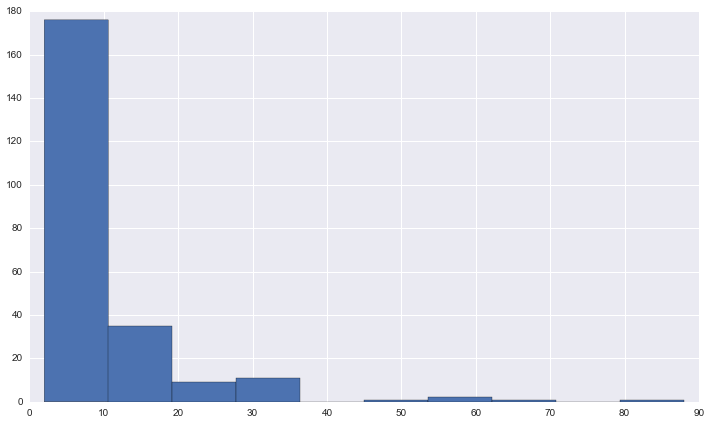

In [13]:
pd.Series(list(deg.values())).hist()

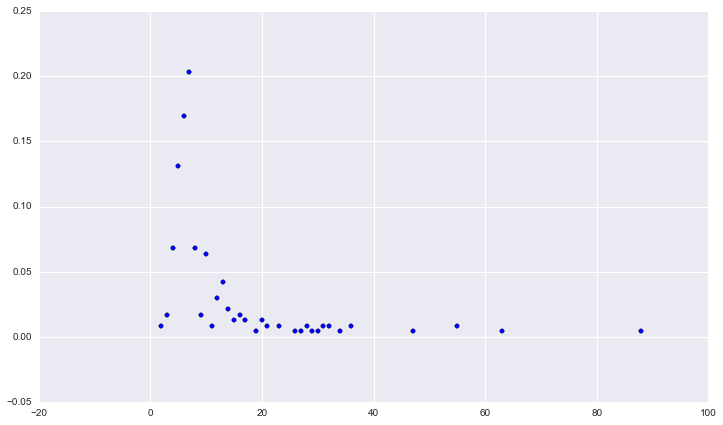

In [14]:
deg_prob = prob_dist(list(deg.values()))
plt.scatter(deg_prob.index, deg_prob)

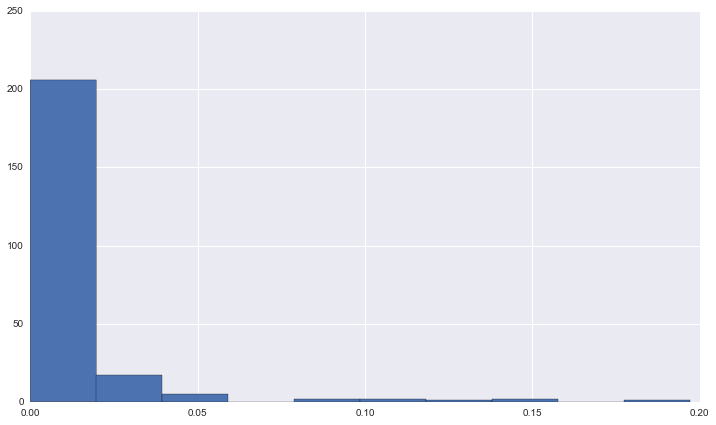

In [15]:
pd.Series(list(bc.values())).hist()

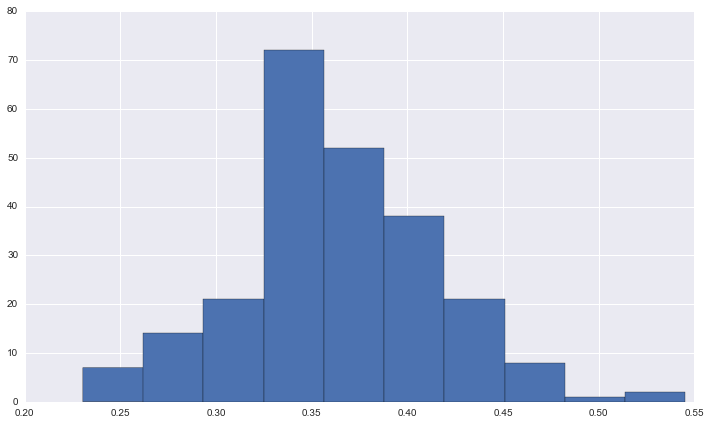

In [16]:
pd.Series(list(cc.values())).hist()

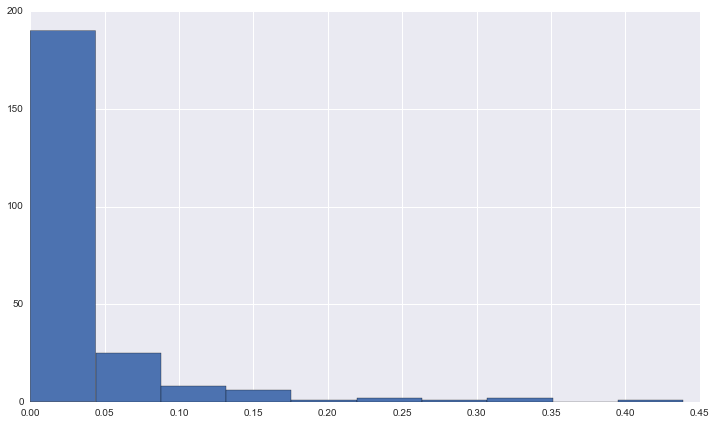

In [17]:
pd.Series(list(ec.values())).hist()

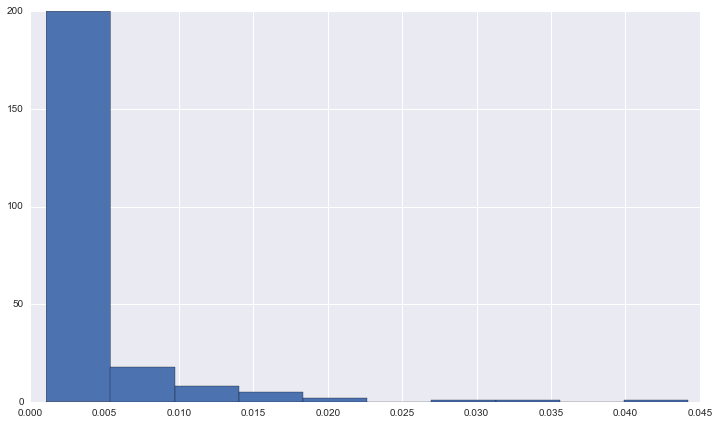

In [18]:
pd.Series(list(pr.values())).hist()

### Assortativity

#### Degree

In [19]:
nx.degree_assortativity_coefficient(g)

-0.13397654720435853

In [20]:
r = nx.degree_assortativity_coefficient(g)
print("%3.1f"%r)

-0.1


In [21]:
nodes_by_deg = sorted(deg, key=deg.get, reverse=True)
mtrx = nx.to_numpy_matrix(g, nodelist=nodes_by_deg)

In [22]:
weight_sr = pd.Series([attrs["weight"] for s, t, attrs in g.edges(data=True)])
weight_sr.describe()

count    1233.000000
mean        0.281060
std         0.233581
min         0.142857
25%         0.166667
50%         0.200000
75%         0.309524
max         2.602381
dtype: float64

In [23]:
quant = weight_sr.quantile(.75)

In [24]:
plt.rcParams['figure.figsize'] = (12, 7)
mtrx

matrix([[ 0.        ,  1.67604428,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 1.67604428,  0.        ,  0.77738095, ...,  0.        ,
          0.19444444,  0.        ],
        [ 0.        ,  0.77738095,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ..., 
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.19444444,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]])

In [25]:
#colors = [('purple')] + [(cm.jet(i)) for i in xrange(1,256)]
#new_map = clrs.LinearSegmentedColormap.from_list('new_map', colors, N=256)
# heatmap = plt.imshow(mtrx, interpolation='nearest')
# heatmap.set_clim(0.0, quant)
# plt.colorbar()
# sns.heatmap(mtrx)
# plt.savefig("img/cutlines_deg_assort.png")


In [26]:
stripmtrx = mtrx[:100, :50]

In [27]:
# heatmap = plt.imshow(stripmtrx)
# heatmap.set_clim(0.0, quant)
# plt.colorbar()
# sns.heatmap(stripmtrx)

In [28]:
zoommtrx = nx.to_numpy_matrix(g, nodelist=nodes_by_deg)[:50, :10]

In [29]:
zoomquant = pd.Series(zoommtrx.flatten().tolist()[0]).quantile(0.9)

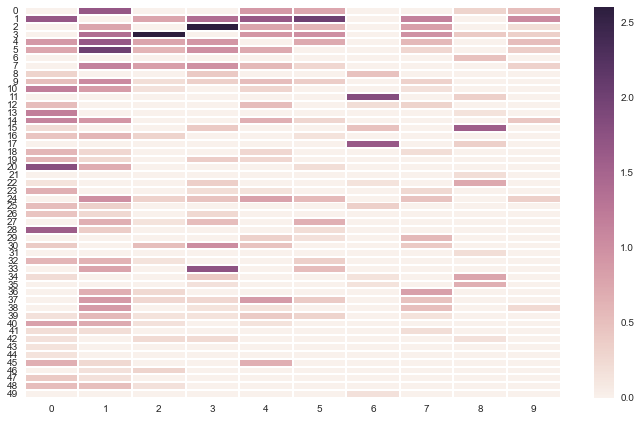

In [30]:
# heatmap = plt.imshow(zoommtrx)
# heatmap.set_clim(0.0, zoomquant)
# plt.colorbar()
sns.heatmap(zoommtrx)

#### Attribute

In [31]:
place = nx.attribute_assortativity_coefficient(g, "top_place")

In [32]:
genre = nx.attribute_assortativity_coefficient(g, "top_genre")

In [33]:
role = nx.attribute_assortativity_coefficient(g, "role")

In [34]:
assort_df = pd.Series({
    "deg": r,
    "role": role,
    "place": place,
    "genre": genre
})
assort_df

deg     -0.133977
genre    0.455555
place    0.251043
role    -0.121747
dtype: float64

Remove author/patron

In [35]:
no_auth_patron = g.copy()
# g.nodes(data=True)

In [36]:
no_auth_patron = g.copy()
for node, attrs in g.nodes(data=True):
    if attrs.get("role", "") == "author" or attrs.get("role", "") == "patron" or not attrs.get("top_place"):
        no_auth_patron.remove_node(node)

In [37]:
len(no_auth_patron.nodes())
place = nx.attribute_assortativity_coefficient(no_auth_patron, "top_place")
place

0.6271698019463784

In [38]:
comps = list(nx.connected_component_subgraphs(no_auth_patron))
for x in comps:
    print(len(x.nodes()))

2
105
22
9
4
4
5
5
1
1


In [39]:
def group_by_top_place(g):
    places = {}
    current = 1
    for n, attrs in g.nodes(data=True):
        tp = attrs["top_place"]
        if tp not in places:
            places[tp] = int(current)
            group = int(current)
            current += 1
        else:
            group = places[tp]
        g.node[n]["group"] = group
    return g

In [40]:
no_auth_patron = group_by_top_place(no_auth_patron)
no_auth_patron.nodes(data=True)

[('163',
  {'avg_date': '1605',
   'doc_type': "{u'Impresion': 3}",
   'fecha': "{'1611-01-01': 1, '1603-08-26': 2}",
   'genero': "{'Ficcion': 2, 'Poesia': 1}",
   'group': 1,
   'label': 'Jeronimo Bordon',
   'lugar': "{u'Milan': 3}",
   'real': "{'True': 1}",
   'role': 'printer/editor',
   'second_genre': 'Poesia',
   'second_place': '',
   'top_genre': 'Ficcion',
   'top_place': 'Milan',
   'type': 'Persona'}),
 ('167',
  {'avg_date': '1603',
   'doc_type': "{u'Impresion': 2}",
   'fecha': "{'1603-08-26': 2}",
   'genero': "{'Ficcion': 2}",
   'group': 1,
   'label': 'Pedromartir Locarno',
   'lugar': "{u'Milan': 2}",
   'real': "{'True': 1}",
   'role': 'printer/editor',
   'second_genre': '',
   'second_place': '',
   'top_genre': 'Ficcion',
   'top_place': 'Milan',
   'type': 'Persona'}),
 ('321',
  {'avg_date': '1617',
   'doc_type': "{u'Impresion': 1}",
   'fecha': "{'1617-01-01': 1}",
   'genero': "{'Ficcion': 1}",
   'group': 2,
   'label': 'Juan Bellero',
   'lugar': "{u'A

In [41]:
nx.write_gexf(no_auth_patron, "projections/no_auth_patron.gexf")

Betweenness

In [42]:
b = nx.betweenness_centrality(g)

In [43]:
d = {"author": [], "signatory": [], "patron": [], "printer/editor": []}
for k, v in b.items():
    role = g.node[k].get("role", "")
    if role:
        d[role].append(v)

(0.0, 0.08)

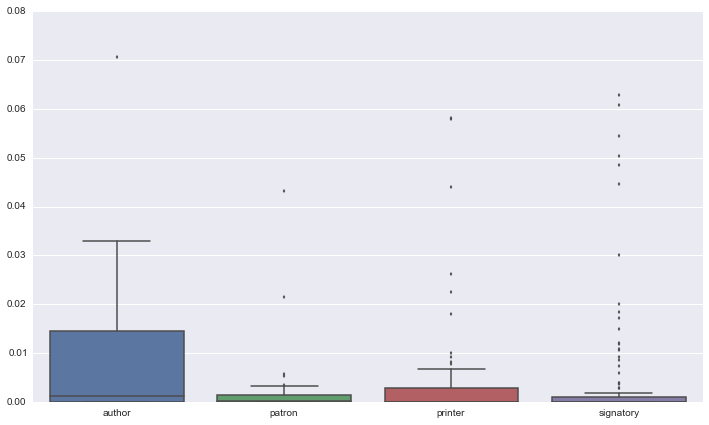

In [44]:
import numpy as np
sns.boxplot([d["author"],  d["patron"], d["printer/editor"], d["signatory"]], names=["author", "patron", "printer", "signatory"])
plt.ylim(0.0, 0.08)

(array([ 17.,   1.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,   1.]),
 array([ 0.        ,  0.03039818,  0.06079637,  0.09119455,  0.12159274,
         0.15199092,  0.18238911,  0.21278729,  0.24318548,  0.27358366,
         0.30398184]),
 <a list of 10 Patch objects>)

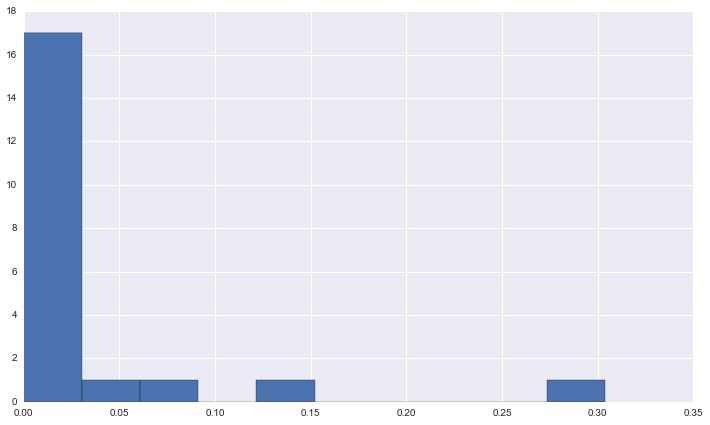

In [45]:
plt.hist(d["author"])

### Clustering

In [46]:
nx.average_clustering(g)

0.8035973273010202

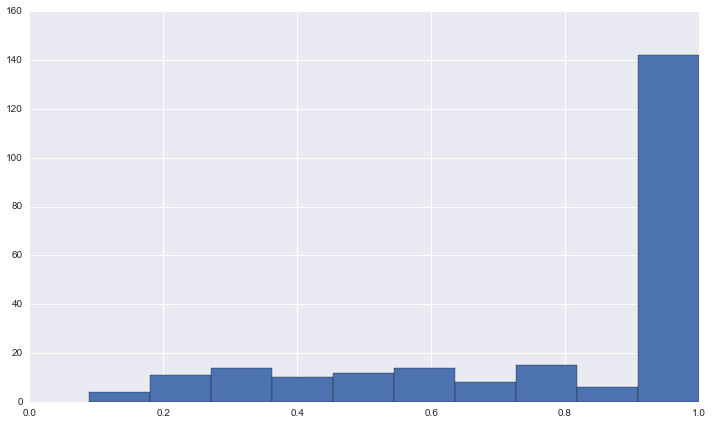

In [48]:
pd.Series(list(nx.clustering(g).values())).hist()

In [49]:
nx.transitivity(g)

0.3290931989924433

### Paths

In [50]:
nx.diameter(g)

6

In [51]:
nx.average_shortest_path_length(g)

2.809700685178507

###Modularity

In [56]:
mod_df = pd.read_csv("data/communities/modularity.csv", encoding="utf-8")
mod_map = {3: 1, 2: 2, 5: 3, 9: 4, 4: 5, 8: 6, 0: 7, 1: 8, 7: 9, 6: 10}
mod_df["Modularity Class"] = mod_df["Modularity Class"].apply(lambda x: mod_map[x])

In [57]:
mod = mod_df.groupby("Modularity Class").size()

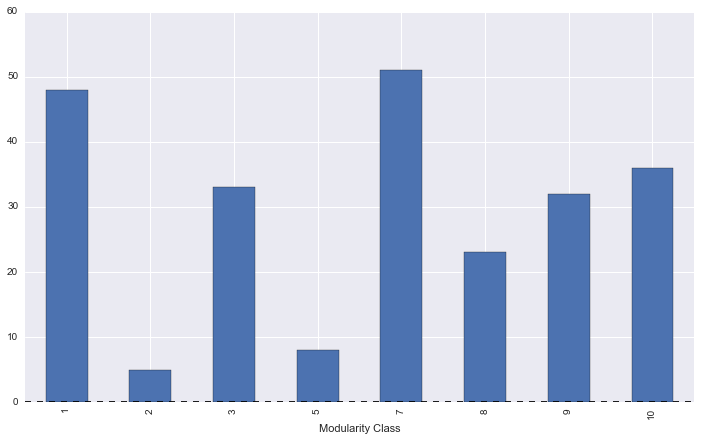

In [58]:
mod.plot(kind="bar")

In [59]:
mod_places = mod_df.groupby(["Modularity Class", "top_place"]).size()

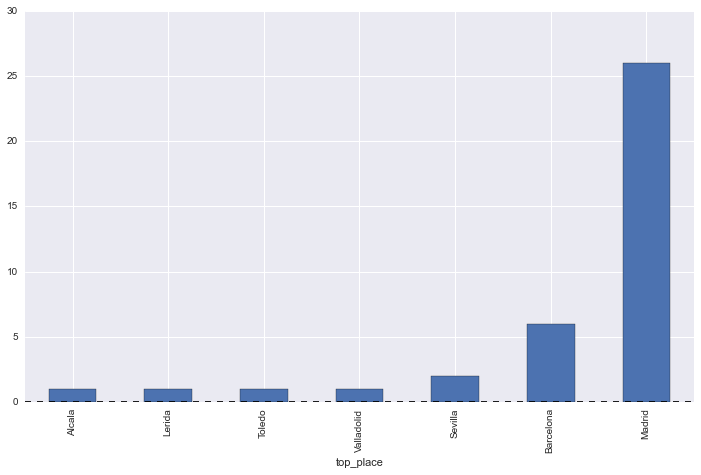

In [60]:
one = mod_places[1]
one.sort()
one.plot(kind="bar")
# Core group Castile -> Aragon

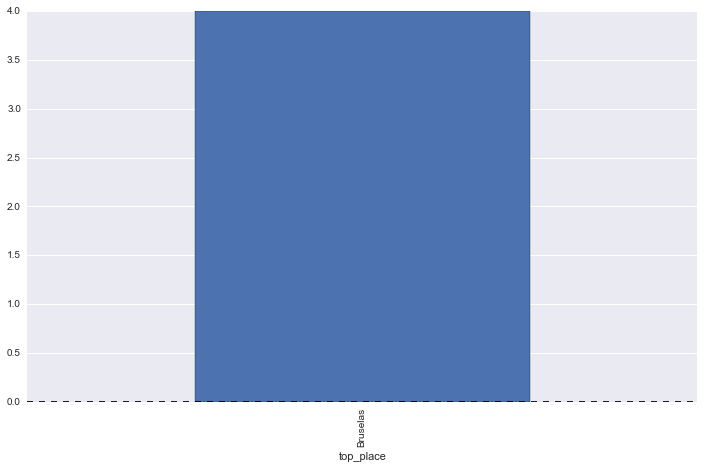

In [61]:
two = mod_places[2]
two.sort()
two.plot(kind="bar")
# Core madrid

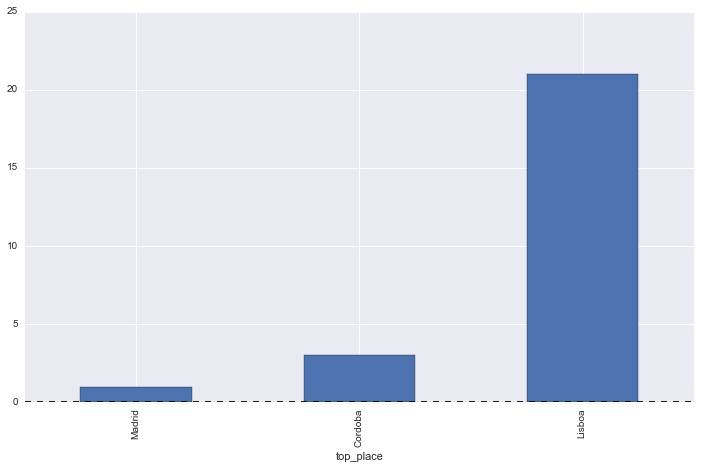

In [62]:
three = mod_places[3]
three.sort()
three.plot(kind="bar")
# Core Zaragoza in between Madrid and Barcelona

In [63]:
four = mod_places[4]
four.sort()
four.plot(kind="bar")
# Aragon

AttributeError: 'numpy.int64' object has no attribute 'plot'

In [ ]:
five = mod_places[5]
five.sort()
five.plot(kind="bar")
# Lisbon

In [64]:
six = mod_places[6]
six.sort()
six.plot(kind="bar")

AttributeError: 'numpy.int64' object has no attribute 'plot'

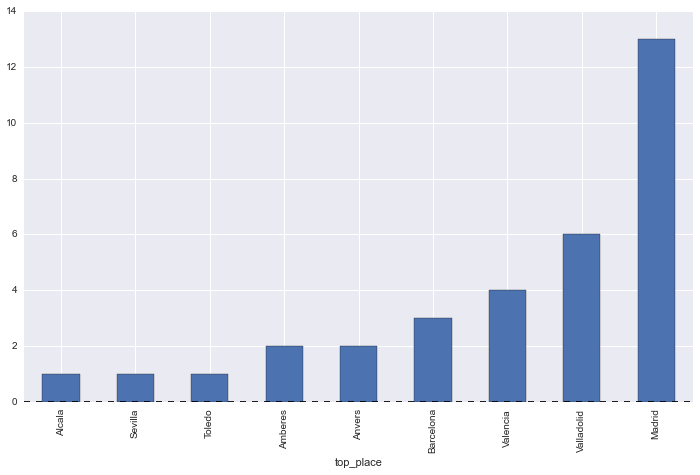

In [65]:
seven = mod_places[7]
seven.sort()
seven.plot(kind="bar")

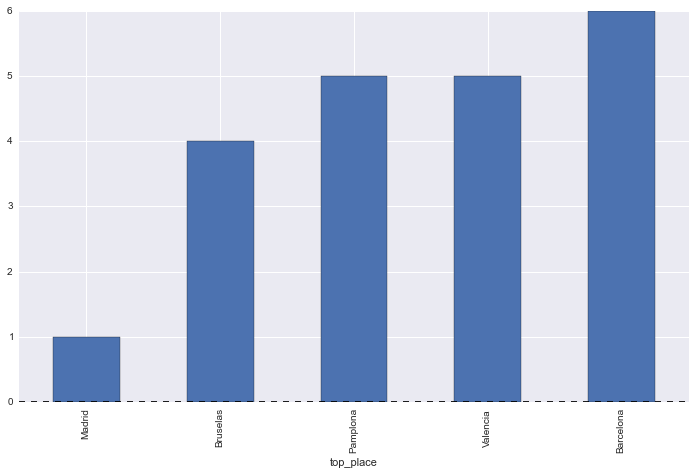

In [66]:
eight = mod_places[8]
eight.sort()
eight.plot(kind="bar")

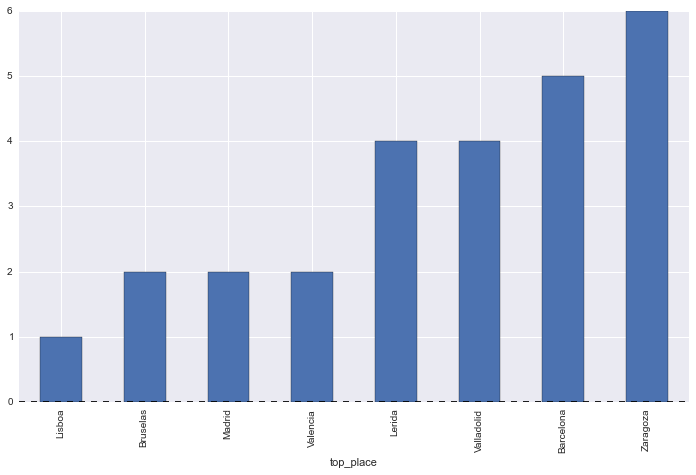

In [67]:
nine = mod_places[9]
nine.sort()
nine.plot(kind="bar")

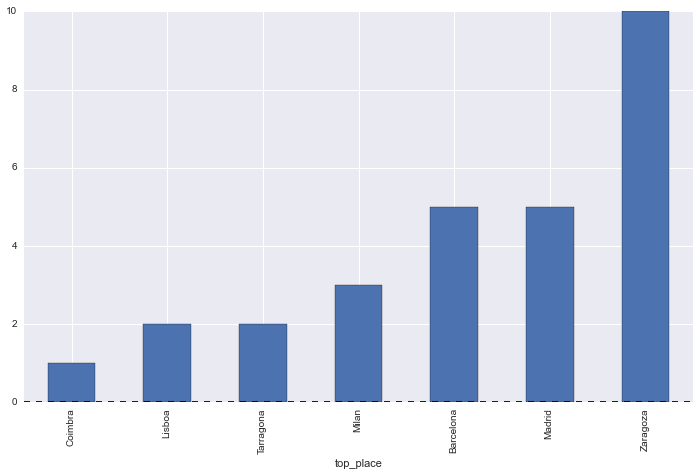

In [68]:
ten = mod_places[10]
ten.sort()
ten.plot(kind="bar")

In [69]:
mod_places = mod_df.groupby(["role", "Modularity Class"]).size()
mod_places

role            Modularity Class
author          1                    7
                2                    1
                3                    2
                5                    1
                7                    3
                8                    1
                9                    4
                10                   2
patron          1                    5
                2                    1
                3                    4
                5                    2
                7                    8
                8                    2
                9                    4
                10                   4
printer/editor  1                    9
                2                    1
                3                    4
                5                    2
                7                   14
                8                    8
                9                    7
                10                  14
signatory       1              

In [70]:
df = pd.DataFrame({
        "author": mod_places["author"],
        "patron": mod_places["patron"],
        "printer/editor": mod_places["printer/editor"],
        "signatory": mod_places["signatory"]})

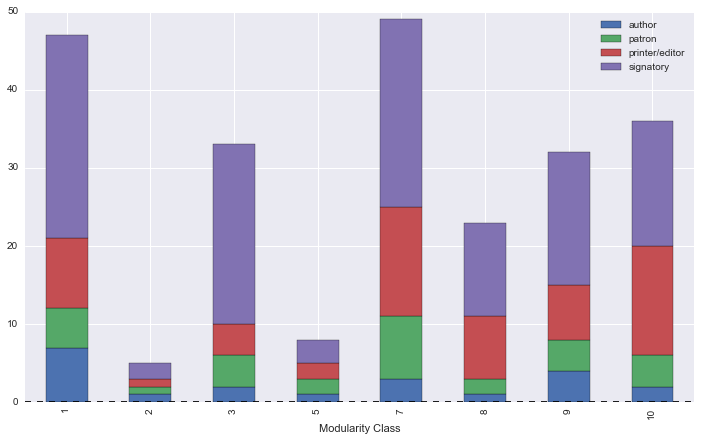

In [71]:
df.plot(kind="bar", stacked=True)

In [72]:
mod_df.groupby([

SyntaxError: unexpected EOF while parsing (<ipython-input-72-bbfed09d89c7>, line 1)

In [ ]:
mod_places = mod_df.groupby(["Modularity Class", "role"]).size()

In [73]:
mod_places = mod_places.reset_index()

In [74]:
mod_places = mod_df.groupby(["Modularity Class", "role"]).size()

In [75]:
grouped = mod_places.groupby(level=0)

In [76]:
grouped.sum()

Modularity Class
1                   47
2                    5
3                   33
5                    8
7                   49
8                   23
9                   32
10                  36
dtype: int64

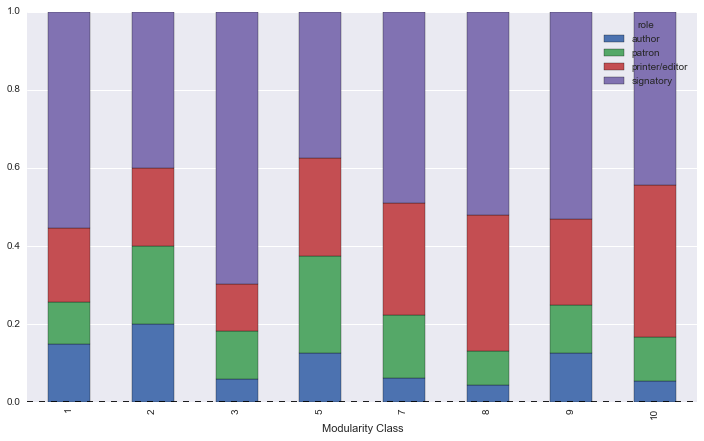

In [77]:
divided = mod_places.divide(grouped.sum())
# divided = divided.reset_index()
divided = divided.unstack(level=0).fillna(0)
trans = divided.transpose()
trans.plot(kind="bar", stacked=True)
# trans

In [78]:
trans

role,author,patron,printer/editor,signatory
Modularity Class,,,,
1,0.148936,0.106383,0.191489,0.553191
2,0.200000,0.200000,0.200000,0.400000
3,0.060606,0.121212,0.121212,0.696970
5,0.125000,0.250000,0.250000,0.375000
7,0.061224,0.163265,0.285714,0.489796
8,0.043478,0.086957,0.347826,0.521739
9,0.125000,0.125000,0.218750,0.531250
10,0.055556,0.111111,0.388889,0.444444


In [82]:
regroup = divided.groupby(["role", "Modularity Class", ])

KeyError: 'role'

In [87]:
len(g.edges())

1233

Interactions

In [241]:
def edge_types(g):
    tps = {}
    for s, t, attrs in g.edges(data=True):
        srole = g.node[s].get("role", "")
        trole = g.node[t].get("role", "")
        if srole and trole:
            if srole == 'patron' and trole == 'printer/editor':
                srole = 'printer/editor'
                trole = 'patron'
            if srole == 'author' and trole == 'patron':
                srole = 'patron'
                trole = 'author'
            if srole == 'author' and trole == 'printer/editor':
                srole = 'printer/editor'
                trole = 'author'
            if srole == 'signatory' and trole == 'patron':
                srole = 'patron'
                trole = 'signatory'
            if srole == 'signatory' and trole == 'printer/editor':
                srole = 'printer/editor'
                trole = 'signatory'
            if srole == 'author' and trole == 'signatory':
                srole = 'signatory'
                trole = 'author'
            if (trole, srole) in tps:
                tps[(trole, srole)].append(attrs["weight"])
            else:
                tps.setdefault((srole, trole), [])
                tps[(srole, trole)].append(attrs.get("weight", 0.0))
    return tps

def edge_aggs(tps, e=1233.0):
    aggs = {}
    for k, v in tps.items():
        aggs[k] = (len(v) / e, sum(v) / len(v))
    return aggs

In [336]:
g = nx.read_gexf('js_viz/graphs/cutlines_gc_from_gephi.gephi')
etps = edge_types(g)
aggs = edge_aggs(etps)
whole = pd.DataFrame(aggs).ix[0]

In [337]:
g1 = nx.read_gexf('js_viz/graphs/mod0_from_gephi.gexf')
etps = edge_types(g1)
aggs = edge_aggs(etps, e=len(g1.edges()))
mod0 = pd.DataFrame(aggs).ix[0]
mod0s = pd.DataFrame(aggs).ix[1]

In [338]:
g2 = nx.read_gexf('js_viz/graphs/mod3_from_gephi.gexf')
etps = edge_types(g2)
aggs = edge_aggs(etps, e=len(g2.edges()))
mod3 = pd.DataFrame(aggs).ix[0]
mod3s = pd.DataFrame(aggs).ix[1]

In [339]:
g3 = nx.read_gexf('js_viz/graphs/mod1_from_gephi.gexf')
etps = edge_types(g3)
aggs = edge_aggs(etps, e=len(g3.edges()))
mod1 = pd.DataFrame(aggs).ix[0]
mod1s = pd.DataFrame(aggs).ix[1]

In [340]:
g4 = nx.read_gexf('js_viz/graphs/mod5_from_gephi.gexf')
etps = edge_types(g4)
aggs = edge_aggs(etps, e=len(g4.edges()))
mod5 = pd.DataFrame(aggs).ix[0]
mod5s = pd.DataFrame(aggs).ix[1]

In [341]:
g5 = nx.read_gexf('js_viz/graphs/mod6_from_gephi.gexf')
etps = edge_types(g5)
aggs = edge_aggs(etps, e=len(g5.edges()))
mod6 = pd.DataFrame(aggs).ix[0]
mod6s = pd.DataFrame(aggs).ix[1]

In [342]:
g6 = nx.read_gexf('js_viz/graphs/mod7_from_gephi.gexf')
etps = edge_types(g6)
aggs = edge_aggs(etps, e=len(g6.edges()))
mod7 = pd.DataFrame(aggs).ix[0]
mod7s = pd.DataFrame(aggs).ix[1]

In [343]:
g7 = nx.read_gexf('js_viz/graphs/mod4_from_gephi.gexf')
etps = edge_types(g7)
aggs = edge_aggs(etps, e=len(g7.edges()))
mod4 = pd.DataFrame(aggs).ix[0]
mod4s = pd.DataFrame(aggs).ix[1]

In [344]:
g8 = nx.read_gexf('js_viz/graphs/mod2_from_gephi.gexf')
etps = edge_types(g8)
aggs = edge_aggs(etps, e=len(g8.edges()))
mod2 = pd.DataFrame(aggs).ix[0]
mod2s = pd.DataFrame(aggs).ix[1]

In [345]:
df = pd.concat([mod0, mod3, mod6, mod5, mod7, mod1, mod4, mod2], axis=1).fillna(0)
df.columns = ['subgroup0', 'subgroup3', 'subgroup6', 'subgroup5', 'subgroup7', 'subgroup1', 'subgroup4', 'subgroup2']
t = df.T
filtered = t[[('patron', 'author'), ('patron', 'signatory'),('printer/editor', 'author'),
              ('printer/editor', 'patron'), ('printer/editor', 'signatory'), ('signatory', 'author'),
              ('printer/editor', 'printer/editor'), ('signatory', 'signatory')]]
filtered
df = filtered.T
df

subgroup0  subgroup3  subgroup6  subgroup5  \
patron         author           0.049020   0.033654   0.020833   0.017094   
               signatory        0.122549   0.110577   0.125000   0.128205   
printer/editor author           0.073529   0.072115   0.104167   0.025641   
               patron           0.088235   0.043269   0.111111   0.042735   
               signatory        0.254902   0.206731   0.326389   0.188034   
signatory      author           0.137255   0.206731   0.104167   0.085470   
printer/editor printer/editor   0.019608   0.009615   0.048611   0.008547   
signatory      signatory        0.142157   0.278846   0.159722   0.504274   

                               subgroup7  subgroup1  subgroup4  subgroup2  
patron         author           0.019802   0.024096   0.074074        0.1  
               signatory        0.168317   0.144578   0.222222        0.2  
printer/editor author           0.079208   0.096386   0.074074        0.1  
               patron           0.059406   0.132530   0.148148        0.1  
               signatory        0.237624   0.277108   0.222222        0.2  
signatory      author           0.168317   0.144578   0.111111        0.2  
printer/editor printer/editor   0.029703   0.048193   0.000000        0.0  
signatory      signatory        0.237624   0.132530   0.111111        0.1

In [346]:
desc = {"patron/author": df.ix['patron'].ix['author'],
        "patron/signatory": df.ix['patron'].ix['signatory'],
        "printer/author": df.ix['printer/editor'].ix['author'],
        "printer/patron": df.ix['printer/editor'].ix['patron'],
        "printer/signatory": df.ix['printer/editor'].ix['signatory'],
        "signatory/author": df.ix['signatory'].ix['author'],
        "printer/printer": df.ix['printer/editor'].ix['printer/editor'],
        "signatory/signatory": df.ix['signatory'].ix['signatory']}
edges_df = pd.DataFrame(desc)

In [347]:
g = nx.read_gexf('js_viz/graphs/cutlines_gc_from_gephi.gephi')
etps = edge_types(g)
aggs = edge_aggs(etps)
whole = pd.DataFrame(aggs).ix[0]
t = whole.T
filtered = t[[('patron', 'author'), ('patron', 'signatory'),('printer/editor', 'author'),
              ('printer/editor', 'patron'), ('printer/editor', 'signatory'), ('signatory', 'author'),
              ('printer/editor', 'printer/editor'), ('signatory', 'signatory')]]

whole = filtered.T
# whole.colums=["patron/author", "patron/signatory","printer/author", "printer/patron", "printer/signatory",
#           "signatory/author","printer/printer", "signatory/signatory" ]

whole = whole.reset_index()
whole

,level_0,level_1,0
0,patron,author,0.033252
1,patron,signatory,0.133820
2,printer/editor,author,0.085969
3,printer/editor,patron,0.078670
4,printer/editor,signatory,0.231955
5,signatory,author,0.166261
6,printer/editor,printer/editor,0.024331
7,signatory,signatory,0.205191


In [351]:
sr = whole[0]
sr.index = ["patron/author", "patron/signatory","printer/author", "printer/patron", "printer/signatory",
          "signatory/author","printer/printer", "signatory/signatory" ]

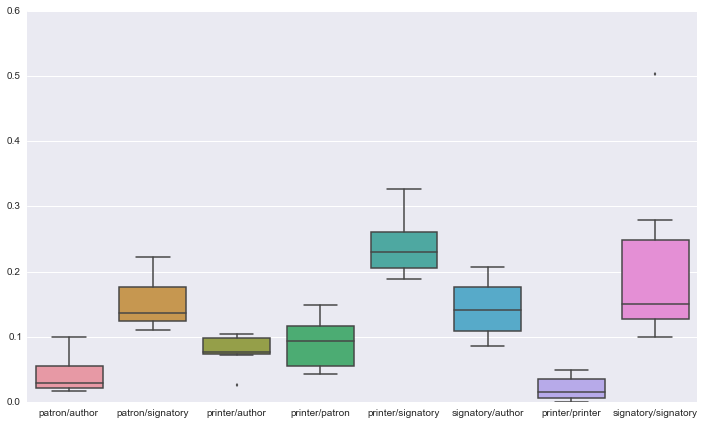

In [350]:
# fig = plt.figure()
# ax1 = fig.add_subplot(111)
ax1 = sns.boxplot([
    edges_df["patron/author"],
    edges_df["patron/signatory"],
    edges_df["printer/author"],
    edges_df["printer/patron"],
    edges_df["printer/signatory"],
    edges_df["signatory/author"],
    edges_df["printer/printer"],
    edges_df["signatory/signatory"]
], names=["patron/author", "patron/signatory","printer/author", "printer/patron", "printer/signatory",
          "signatory/author","printer/printer", "signatory/signatory" ])
# ax2 = ax1.twinx()
# ax1.plot(ax1.get_xticks(), sr)
# plt.ylim(0, 0.4)

In [352]:
df2 = pd.concat([mod0s, mod3s, mod6s, mod5s, mod7s, mod1s, mod4s, mod2s], axis=1).fillna(0)
df2.columns = ['subgroup0', 'subgroup3', 'subgroup6', 'subgroup5', 'subgroup7', 'subgroup1', 'subgroup4', 'subgroup2']
t = df2.T
filtered = t[[('patron', 'author'), ('patron', 'signatory'),('printer/editor', 'author'),
              ('printer/editor', 'patron'), ('printer/editor', 'signatory'), ('signatory', 'author'),
              ('printer/editor', 'printer/editor'), ('signatory', 'signatory')]]

df2 = filtered.T
df2

subgroup0  subgroup3  subgroup6  subgroup5  \
patron         author           0.464841   0.463265   0.654365   0.196429   
               signatory        0.332603   0.240787   0.354101   0.157143   
printer/editor author           0.444921   0.238716   0.179444   0.239286   
               patron           0.201323   0.204762   0.208854   0.164286   
               signatory        0.204777   0.309086   0.191008   0.318398   
signatory      author           0.439229   0.325832   0.364921   0.231429   
printer/editor printer/editor   0.399206   0.210317   0.181633   0.142857   
signatory      signatory        0.290189   0.374504   0.267857   0.249496   

                               subgroup7  subgroup1  subgroup4  subgroup2  
patron         author           0.396429   2.167857   0.309524        0.2  
               signatory        0.186835   0.337897   0.309524        0.2  
printer/editor author           0.227381   0.436756   0.154762        0.2  
               patron           0.181151   0.317641   0.154762        0.2  
               signatory        0.240179   0.235197   0.154762        0.2  
signatory      author           0.297059   0.337897   0.309524        0.2  
printer/editor printer/editor   0.169841   0.189881   0.000000        0.0  
signatory      signatory        0.215675   0.245346   0.309524        0.2

In [354]:
desc2 = {"patron/author": df2.ix['patron'].ix['author'],
        "patron/signatory": df2.ix['patron'].ix['signatory'],
        "printer/author": df2.ix['printer/editor'].ix['author'],
        "printer/patron": df2.ix['printer/editor'].ix['patron'],
        "printer/signatory": df2.ix['printer/editor'].ix['signatory'],
        "signatory/author": df2.ix['signatory'].ix['author'],
        "printer/printer": df2.ix['printer/editor'].ix['printer/editor'],
        "signatory/signatory": df2.ix['signatory'].ix['signatory']}
strength_df = pd.DataFrame(desc2)

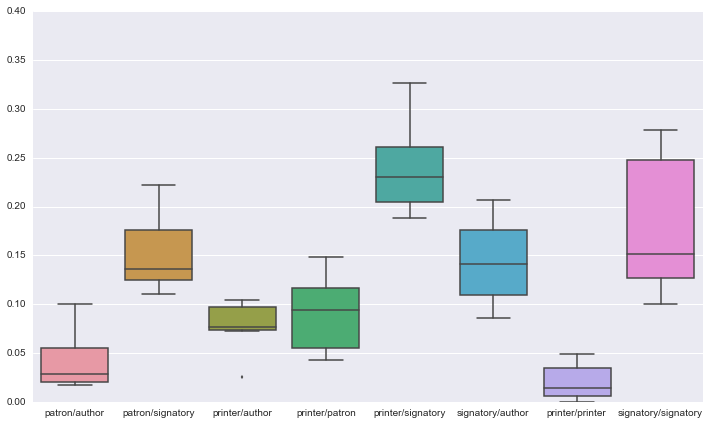

In [358]:
ax1 = sns.boxplot([
    edges_df["patron/author"],
    edges_df["patron/signatory"],
    edges_df["printer/author"],
    edges_df["printer/patron"],
    edges_df["printer/signatory"],
    edges_df["signatory/author"],
    edges_df["printer/printer"],
    edges_df["signatory/signatory"]
], names=["patron/author", "patron/signatory","printer/author", "printer/patron", "printer/signatory",
          "signatory/author","printer/printer", "signatory/signatory" ])
plt.ylim(0, 0.4)
plt.savefig("img/percent_edges_box.png")

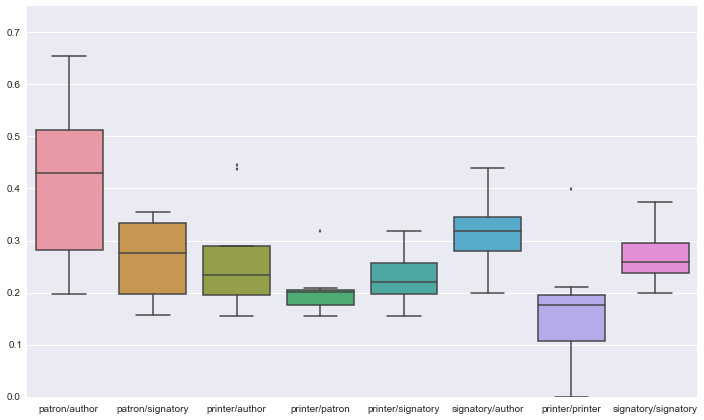

In [359]:
ax1 = sns.boxplot([
    strength_df["patron/author"],
    strength_df["patron/signatory"],
    strength_df["printer/author"],
    strength_df["printer/patron"],
    strength_df["printer/signatory"],
    strength_df["signatory/author"],
    strength_df["printer/printer"],
    strength_df["signatory/signatory"]
], names=["patron/author", "patron/signatory","printer/author", "printer/patron", "printer/signatory",
          "signatory/author","printer/printer", "signatory/signatory" ])
plt.ylim(0, 0.75)
plt.savefig("img/percent_edgestrength_box.png")

In [360]:
strength_df

,patron/author,patron/signatory,printer/author,printer/patron,printer/printer,printer/signatory,signatory/author,signatory/signatory
subgroup0,0.464841,0.332603,0.444921,0.201323,0.399206,0.204777,0.439229,0.290189
subgroup3,0.463265,0.240787,0.238716,0.204762,0.210317,0.309086,0.325832,0.374504
subgroup6,0.654365,0.354101,0.179444,0.208854,0.181633,0.191008,0.364921,0.267857
subgroup5,0.196429,0.157143,0.239286,0.164286,0.142857,0.318398,0.231429,0.249496
subgroup7,0.396429,0.186835,0.227381,0.181151,0.169841,0.240179,0.297059,0.215675
subgroup1,2.167857,0.337897,0.436756,0.317641,0.189881,0.235197,0.337897,0.245346
subgroup4,0.309524,0.309524,0.154762,0.154762,0.000000,0.154762,0.309524,0.309524
subgroup2,0.200000,0.200000,0.200000,0.200000,0.000000,0.200000,0.200000,0.200000


In [361]:
strength_df.mean()

patron/author          0.606589
patron/signatory       0.264861
printer/author         0.265158
printer/patron         0.204097
printer/printer        0.161717
printer/signatory      0.231676
signatory/author       0.313236
signatory/signatory    0.269074
dtype: float64

In [362]:
edges_df.mean()

patron/author          0.042322
patron/signatory       0.152681
printer/author         0.078140
printer/patron         0.090679
printer/printer        0.020535
printer/signatory      0.239126
signatory/author       0.144704
signatory/signatory    0.208283
dtype: float64

In [363]:
edf = pd.concat([strength_df.mean(), edges_df.mean()], axis=1)

In [365]:
edf.columns = ["weight", "freq"]

In [366]:
edf

,weight,freq
patron/author,0.606589,0.042322
patron/signatory,0.264861,0.152681
printer/author,0.265158,0.078140
printer/patron,0.204097,0.090679
printer/printer,0.161717,0.020535
printer/signatory,0.231676,0.239126
signatory/author,0.313236,0.144704
signatory/signatory,0.269074,0.208283


(0.0, 0.7)

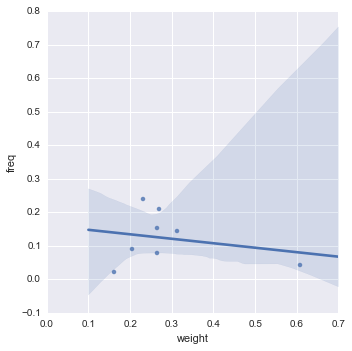

In [368]:
sns.lmplot(x="weight", y="freq", data=edf)
plt.xlim(0.0, 0.7)

In [275]:
tips = sns.load_dataset("tips")

In [276]:
tips

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
5,25.29,4.71,Male,No,Sun,Dinner,4
6,8.77,2.00,Male,No,Sun,Dinner,2
7,26.88,3.12,Male,No,Sun,Dinner,4
8,15.04,1.96,Male,No,Sun,Dinner,2
9,14.78,3.23,Male,No,Sun,Dinner,2


In [185]:
chisquare(df.whole.values, df.mod0.values)

(inf, nan)

In [186]:
whole

author          author            0.004866
patron          author            0.033252
                patron            0.002433
                signatory         0.133820
printer/editor  author            0.085969
                patron            0.078670
                printer/editor    0.024331
                signatory         0.231955
signatory       author            0.166261
                signatory         0.205191
Name: 0, dtype: float64

In [132]:
whole

author          author            0.004866
patron          author            0.033252
                patron            0.002433
                signatory         0.133820
printer/editor  author            0.085969
                patron            0.078670
                printer/editor    0.024331
                signatory         0.231955
signatory       author            0.166261
                signatory         0.205191
Name: 0, dtype: float64

In [133]:
mod0

author          author            0.004902
patron          author            0.049020
                printer/editor    0.088235
                signatory         0.122549
printer/editor  author            0.073529
                printer/editor    0.019608
                signatory         0.254902
signatory       author            0.137255
                signatory         0.142157
Name: 0, dtype: float64

In [135]:
mod0['printer/editor']['patron'] = 0.0

In [136]:
mod0

author          author            0.004902
patron          author            0.049020
                printer/editor    0.088235
                signatory         0.122549
printer/editor  author            0.073529
                printer/editor    0.019608
                signatory         0.254902
signatory       author            0.137255
                signatory         0.142157
Name: 0, dtype: float64

In [94]:
def count_roles(g):
    d = {}
    for n, a, in g.nodes(data=True):
        role = a.get("role")
        if role:
            d.setdefault(role, 0)
            d[role] += 1
    return d

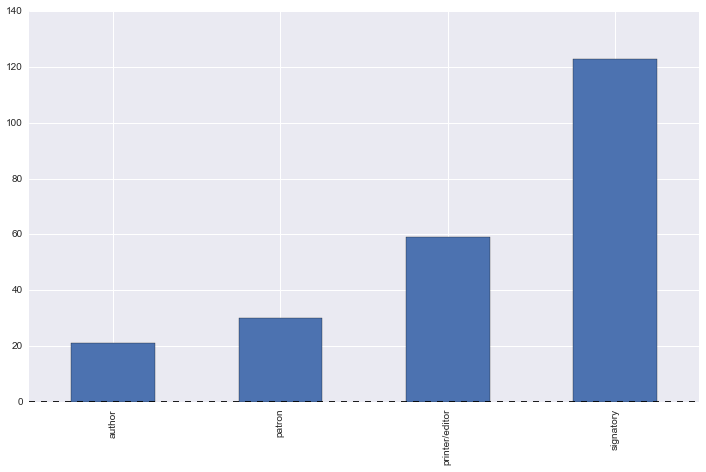

In [102]:
pd.Series(count_roles(g)).plot(kind="bar")
plt.savefig("img/role_dist.png")